# Задание: обучить word2vec методом Skipgram

In [1]:
import json
import random
from tqdm import tqdm
import numpy as np

from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import torch

from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

# Загружаем данные
Они уже обработанные и токенизированные.

In [2]:
with open('data/processed_corpus.json') as f:
    corpus = json.load(f)

In [3]:
len(corpus)

100000

In [4]:
for text in corpus[:5]:
    print(' '.join(text))

наш риэлтор мы ипотека выйти UNK оформлять ипотека сбер
решить обратиться другой отделение который находиться мир ##число
воробьев неизвестно это UNK момент
один посоветовать обратиться банк продавец просьба перечислить деньга обратно
собрать документ отсканировать отослать почта UNK sberbank ru ##число ноябрь


# CBOW

In [5]:
sample_text = corpus[1]

In [6]:
' '.join(sample_text)

'решить обратиться другой отделение который находиться мир ##число'

# Разделить предложения на примеры методом CBOW

In [7]:
def cbow_split(tokens, window, pad_token='PAD'):
    
    splits = []
    
    for word in tokens:
        index_central = tokens.index(word)
        left = [tokens[i] if i >= 0 else 'PAD' for i in range(index_central - window, index_central)]
        right = [tokens[i] if i < len(tokens) else 'PAD' for i in range(index_central + 1, \
                                                                            index_central + 1 + window)]
        splits.append((left, word, right))
    return splits

In [8]:
splits = cbow_split(sample_text, window=2)

In [9]:
for sample in splits:
    print('Левый контекст:', sample[0])
    print('Центральное слово:', sample[1])
    print('Правый контекст:', sample[2], end='\n\n')

Левый контекст: ['PAD', 'PAD']
Центральное слово: решить
Правый контекст: ['обратиться', 'другой']

Левый контекст: ['PAD', 'решить']
Центральное слово: обратиться
Правый контекст: ['другой', 'отделение']

Левый контекст: ['решить', 'обратиться']
Центральное слово: другой
Правый контекст: ['отделение', 'который']

Левый контекст: ['обратиться', 'другой']
Центральное слово: отделение
Правый контекст: ['который', 'находиться']

Левый контекст: ['другой', 'отделение']
Центральное слово: который
Правый контекст: ['находиться', 'мир']

Левый контекст: ['отделение', 'который']
Центральное слово: находиться
Правый контекст: ['мир', '##число']

Левый контекст: ['который', 'находиться']
Центральное слово: мир
Правый контекст: ['##число', 'PAD']

Левый контекст: ['находиться', 'мир']
Центральное слово: ##число
Правый контекст: ['PAD', 'PAD']



In [10]:
cbow_split(sample_text, window=3)

[(['PAD', 'PAD', 'PAD'], 'решить', ['обратиться', 'другой', 'отделение']),
 (['PAD', 'PAD', 'решить'], 'обратиться', ['другой', 'отделение', 'который']),
 (['PAD', 'решить', 'обратиться'],
  'другой',
  ['отделение', 'который', 'находиться']),
 (['решить', 'обратиться', 'другой'],
  'отделение',
  ['который', 'находиться', 'мир']),
 (['обратиться', 'другой', 'отделение'],
  'который',
  ['находиться', 'мир', '##число']),
 (['другой', 'отделение', 'который'], 'находиться', ['мир', '##число', 'PAD']),
 (['отделение', 'который', 'находиться'], 'мир', ['##число', 'PAD', 'PAD']),
 (['который', 'находиться', 'мир'], '##число', ['PAD', 'PAD', 'PAD'])]

# Разделить предложения на примеры методом Skipgram

In [11]:
def skipgram_split(tokens, window):
    
    splits = []
    
    for word in tokens:
        index_central = tokens.index(word)
        splits.extend([(tokens[i], word) for i in range(index_central - window, index_central) if i >= 0]) # left
        splits.extend([(tokens[i], word) for i in range(index_central + 1, index_central + 1 + window) \
                       if i < len(tokens)]) # right
        
    return splits

In [12]:
splits = skipgram_split(sample_text, window=2)

In [13]:
for sample in splits:
    print('Контекст:', sample[0])
    print('Центральное слово:', sample[1], end='\n\n')

Контекст: обратиться
Центральное слово: решить

Контекст: другой
Центральное слово: решить

Контекст: решить
Центральное слово: обратиться

Контекст: другой
Центральное слово: обратиться

Контекст: отделение
Центральное слово: обратиться

Контекст: решить
Центральное слово: другой

Контекст: обратиться
Центральное слово: другой

Контекст: отделение
Центральное слово: другой

Контекст: который
Центральное слово: другой

Контекст: обратиться
Центральное слово: отделение

Контекст: другой
Центральное слово: отделение

Контекст: который
Центральное слово: отделение

Контекст: находиться
Центральное слово: отделение

Контекст: другой
Центральное слово: который

Контекст: отделение
Центральное слово: который

Контекст: находиться
Центральное слово: который

Контекст: мир
Центральное слово: который

Контекст: отделение
Центральное слово: находиться

Контекст: который
Центральное слово: находиться

Контекст: мир
Центральное слово: находиться

Контекст: ##число
Центральное слово: находиться

Ко

In [14]:
skipgram_split(sample_text, window=2)

[('обратиться', 'решить'),
 ('другой', 'решить'),
 ('решить', 'обратиться'),
 ('другой', 'обратиться'),
 ('отделение', 'обратиться'),
 ('решить', 'другой'),
 ('обратиться', 'другой'),
 ('отделение', 'другой'),
 ('который', 'другой'),
 ('обратиться', 'отделение'),
 ('другой', 'отделение'),
 ('который', 'отделение'),
 ('находиться', 'отделение'),
 ('другой', 'который'),
 ('отделение', 'который'),
 ('находиться', 'который'),
 ('мир', 'который'),
 ('отделение', 'находиться'),
 ('который', 'находиться'),
 ('мир', 'находиться'),
 ('##число', 'находиться'),
 ('который', 'мир'),
 ('находиться', 'мир'),
 ('##число', 'мир'),
 ('находиться', '##число'),
 ('мир', '##число')]

In [15]:
skipgram_split(sample_text, window=3)

[('обратиться', 'решить'),
 ('другой', 'решить'),
 ('отделение', 'решить'),
 ('решить', 'обратиться'),
 ('другой', 'обратиться'),
 ('отделение', 'обратиться'),
 ('который', 'обратиться'),
 ('решить', 'другой'),
 ('обратиться', 'другой'),
 ('отделение', 'другой'),
 ('который', 'другой'),
 ('находиться', 'другой'),
 ('решить', 'отделение'),
 ('обратиться', 'отделение'),
 ('другой', 'отделение'),
 ('который', 'отделение'),
 ('находиться', 'отделение'),
 ('мир', 'отделение'),
 ('обратиться', 'который'),
 ('другой', 'который'),
 ('отделение', 'который'),
 ('находиться', 'который'),
 ('мир', 'который'),
 ('##число', 'который'),
 ('другой', 'находиться'),
 ('отделение', 'находиться'),
 ('который', 'находиться'),
 ('мир', 'находиться'),
 ('##число', 'находиться'),
 ('отделение', 'мир'),
 ('который', 'мир'),
 ('находиться', 'мир'),
 ('##число', 'мир'),
 ('который', '##число'),
 ('находиться', '##число'),
 ('мир', '##число')]

In [16]:
word2index = {}

for text in corpus:
    for token in text:
        if token not in word2index:
            word2index[token] = len(word2index)

In [17]:
len(word2index)

13128

In [18]:
word2index['UNK']

5

In [19]:
[word2index[tok] if tok in word2index else word2index['UNK'] for tok in 'мама мыть рама'.split()]

[502, 1363, 5]

# Мы будем учить модель Skipgram
Читалка данных:

In [20]:
from torch.utils.data import Dataset, DataLoader

In [21]:
class SkipgramDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 collect_verbose=True):

        self.corpus = corpus
        self.word2index = word2index
        self.index2word = {value: key for key, value in self.word2index.items()}
        self.window = window

        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]

        self.collect_verbose = collect_verbose

        self.data = []

        self.collect_data()
        

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokens):
        
        splits = []
        
        for word in tokens:
            index_central = tokens.index(word)
            splits.extend([(tokens[i], word) for i in range(index_central - self.window, index_central) \
                           if i >= 0]) # left
            splits.extend([(tokens[i], word) for i in range(index_central + 1, index_central + 1 + self.window) \
                       if i < len(tokens)]) # right

        return splits

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            skipgram_examples = self._split_function(indexed_text)

            self.data.extend(skipgram_examples)

    def __getitem__(self, idx):
        
        context, central_word = self.data[idx]

        return context, central_word

In [22]:
dataset = SkipgramDataset(corpus, word2index)

100%|██████████| 100000/100000 [00:04<00:00, 20773.47it/s]


In [23]:
BATCH_SIZE = 512

In [24]:
dataset_loader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)

In [25]:
for x, y in dataset_loader:
    break

In [26]:
x[:5]

tensor([  45,  373,  521,   11, 2674])

In [27]:
y[:5]

tensor([177, 631, 272, 919, 151])

In [28]:
x.shape, y.shape

(torch.Size([512]), torch.Size([512]))

Реализация модели Skipgram

In [29]:
class SkipGram(torch.nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        
        super().__init__()
        
        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size, 
                                               embedding_dim=embedding_dim)
        
        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=False)
        
    def forward(self, x):
        
        x = self.in_embedding(x)
        x = self.out_embedding(x)
        
        return x

In [30]:
EMBEDDING_DIM = 20

In [31]:
model = SkipGram(vocab_size=len(word2index), embedding_dim=EMBEDDING_DIM)

In [32]:
with torch.no_grad():
    pred = model(x)

pred.shape

torch.Size([512, 13128])

In [33]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [34]:
epochs = 3

losses = []

for n_epoch in range(epochs):

    try:

        progress_bar = tqdm(total=len(dataset_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))

        for x, y in dataset_loader:
            
            optimizer.zero_grad()
            x_out = model(x)
            loss = criterion(x_out, y)
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
            
            progress_bar.set_postfix(loss=np.mean(losses[-100:]))

            progress_bar.update(x.shape[0])

        progress_bar.close()

    except KeyboardInterrupt:

        progress_bar.close()
        break

Epoch 3: 100%|██████████| 2992029/2992029 [08:47<00:00, 5877.25it/s, loss=6.9] 


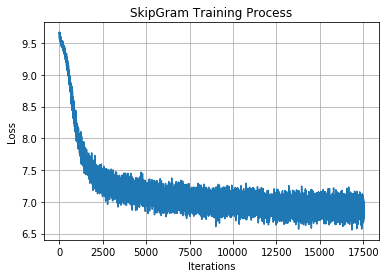

In [35]:
plt.title('SkipGram Training Process')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()
plt.plot(losses)

In [37]:
embedding_matrix = model.in_embedding.weight.detach()

In [38]:
def cos_sim(embedding_matrix, token2id, word1, word2):
    
    i1 = token2id[word1]
    i2 = token2id[word2]
    
    v1, v2 = embedding_matrix[i1], embedding_matrix[i2]
    
    v1_n = v1.div(v1.norm(keepdim=True))
    v2_n = v2.div(v2.norm(keepdim=True))
    
    similarity = torch.dot(v1_n, v2_n).item()
    
    return similarity

# Косинусная близость

In [39]:
cos_sim(embedding_matrix, word2index, 'день', 'месяц')

0.5763727426528931

In [40]:
cos_sim(embedding_matrix, word2index, 'минута', 'месяц')

0.518550455570221

In [41]:
cos_sim(embedding_matrix, word2index, 'сотрудник', 'сотрудница')

0.8640899062156677

In [42]:
cos_sim(embedding_matrix, word2index, 'вклад', 'перевод')

0.1611856073141098

In [43]:
random_word = random.choice(list(word2index.keys()))
sim = cos_sim(embedding_matrix, word2index, 'день', random_word)
'Косинусная близость слова "день" к случайному выбраному слову "{}" равна {:.3f}'.format(random_word, sim)

'Косинусная близость слова "день" к случайному выбраному слову "срабатывать" равна 0.255'

In [44]:
freq = {}

for text in corpus:
    for token in text:
        if token in freq:
            freq[token] += 1
        else:
            freq[token] = 1

In [45]:
sorted_freq = [(k, freq[k]) for k in sorted(freq, key=freq.get, reverse=True)]
top_sorted_freq = sorted_freq[0:200]

In [46]:
tsne = TSNE(n_components=2, random_state=42, verbose=2)
reduced = tsne.fit_transform(embedding_matrix)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 13128 samples in 0.021s...
[t-SNE] Computed neighbors for 13128 samples in 13.668s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13128
[t-SNE] Computed conditional probabilities for sample 2000 / 13128
[t-SNE] Computed conditional probabilities for sample 3000 / 13128
[t-SNE] Computed conditional probabilities for sample 4000 / 13128
[t-SNE] Computed conditional probabilities for sample 5000 / 13128
[t-SNE] Computed conditional probabilities for sample 6000 / 13128
[t-SNE] Computed conditional probabilities for sample 7000 / 13128
[t-SNE] Computed conditional probabilities for sample 8000 / 13128
[t-SNE] Computed conditional probabilities for sample 9000 / 13128
[t-SNE] Computed conditional probabilities for sample 10000 / 13128
[t-SNE] Computed conditional probabilities for sample 11000 / 13128
[t-SNE] Computed conditional probabilities for sample 12000 / 13128
[t-SNE] Computed conditional probabilities for sa

In [47]:
top_words = [a for a,_ in top_sorted_freq]

In [48]:
inds = [word2index[word] for word in top_words]
x_coords = [coords[0] for coords in reduced[inds]]
y_coords = [coords[1] for coords in reduced[inds]]

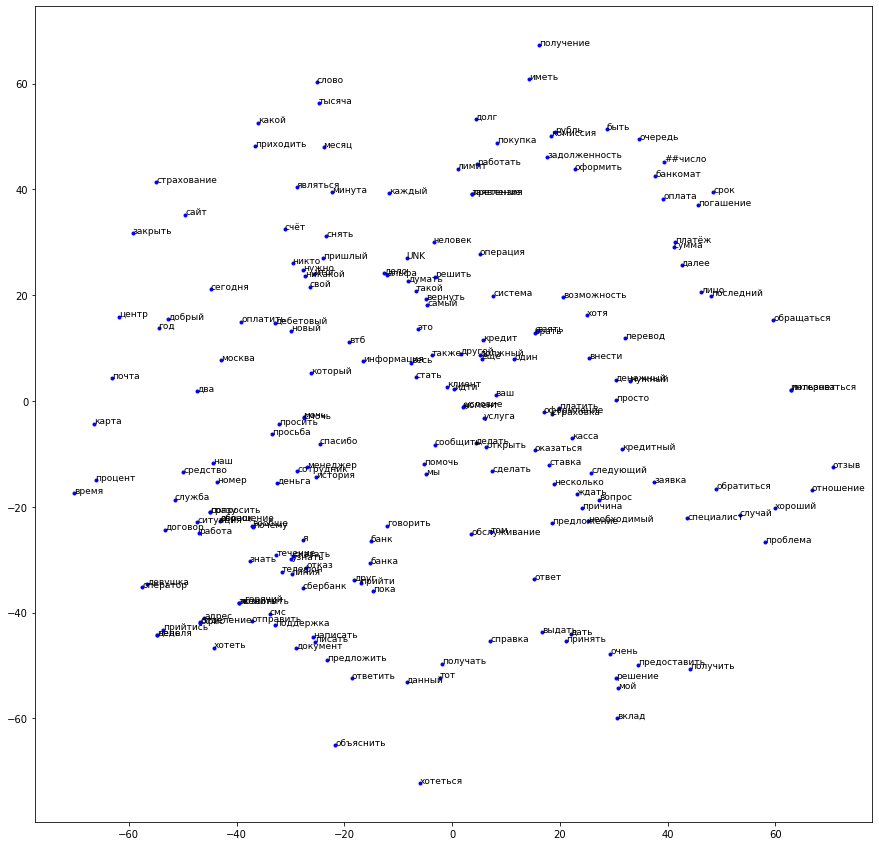

In [49]:
plt.figure(figsize=(15,15))
for (x, y, word) in zip(x_coords, y_coords, top_words):
    plt.scatter(x, y, marker='.', color='blue')
    plt.text(x, y, word, fontsize=9)
plt.show()